In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import math
from scipy import interpolate

import json
import proplot as plot
# plt.rc('font',family='Times New Roman',size=15)

import warnings
warnings.filterwarnings('ignore')

## Burning temperature comparisons

In [2]:
def read(fieldminMaxFile):
    with open(fieldminMaxFile,"r") as fp:
        comment=fp.readline()
        header=fp.readline()
    header=header[1:-1].split()
    indexs_processor=[]
    for i,name in enumerate(header):
        if header[i]=="processor":
            indexs_processor.append(i)
    indexs_processor.reverse()  

    data=pd.read_csv(fieldminMaxFile,comment='#', sep='\t',header=None)
    data=data.drop(indexs_processor,axis=1)
    data.rename(columns=lambda x:header[x],inplace=True)
    return data

In [3]:
data_consider=read("./consider_fieldMinMax.dat")
data_consider.head()

,Time,field,min,location(min),max,location(max)
0,0.000001,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
1,0.000003,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
2,0.000004,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
3,0.000006,T,772.9978,(4.350000e-05 4.450000e-05 5.000000e-07),773.0022,(2.350000e-05 8.450000e-05 5.000000e-07)
4,0.000009,T,772.9976,(6.550000e-05 6.350000e-05 5.000000e-07),773.0077,(2.350000e-05 8.450000e-05 5.000000e-07)


In [4]:
data_notConsider=read("./notConsider_fieldMinMax.dat")
data_notConsider.head()

,Time,field,min,location(min),max,location(max)
0,0.000001,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
1,0.000003,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
2,0.000004,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
3,0.000006,T,772.9981,(4.350000e-05 4.450000e-05 5.000000e-07),773.0027,(2.350000e-05 8.450000e-05 5.000000e-07)
4,0.000009,T,772.9981,(6.550000e-05 6.350000e-05 5.000000e-07),773.0087,(2.350000e-05 8.450000e-05 5.000000e-07)


In [5]:
Tref=773

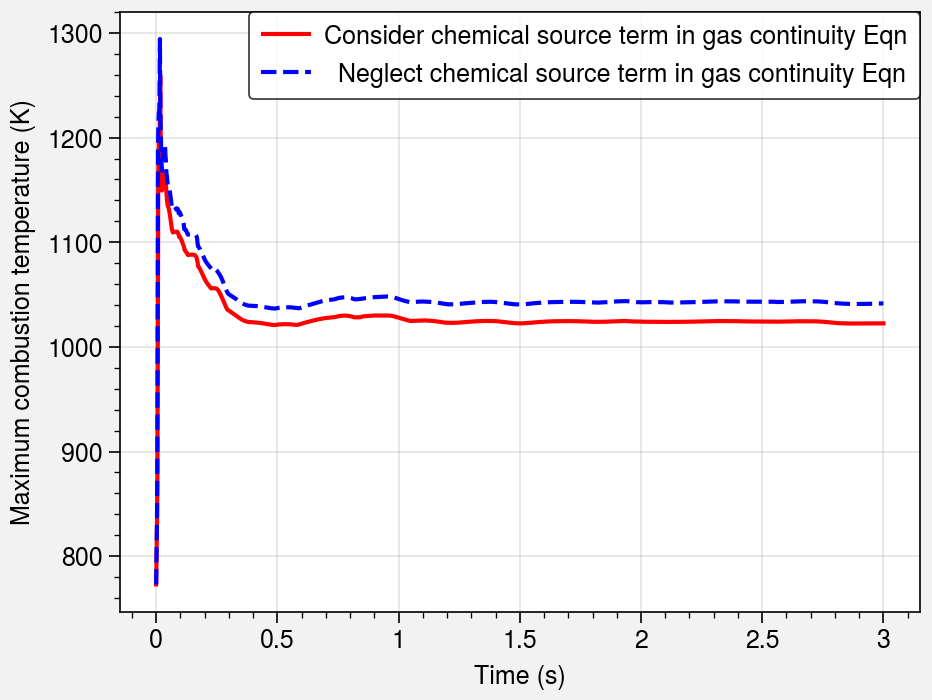

In [6]:
fig, ax = plot.subplots( aspect=(4, 3), axwidth=4)
ax.plot(data_consider["Time"],data_consider["max"],lineStyle="-",color="r",label="Consider chemical source term in gas continuity Eqn")
ax.plot(data_notConsider["Time"],data_notConsider["max"],lineStyle="--",color="b",label="  Neglect chemical source term in gas continuity Eqn")
ax.format(xlabel="Time (s)",ylabel="Maximum combustion temperature (K)")
# ax.set_title(f"Combustion Tempereature Comparison")
ax.legend(loc="upper right",ncol=1,  fancybox=True)

In [7]:
fig.savefig("maximumTemperatureComparison.jpg",bbox_inches='tight',dpi=600)

## Velocity magnitude comparisons 

In [8]:
def readOpenFoamField(file,nx,ny,normizedValue=1):
    with open(file,"r") as fp:
        lines=fp.readlines()
    for i,line in enumerate(lines):
        if line.startswith("internalField"):
            start=i+3
        elif line.startswith("boundaryField"):
            end=i-4
            break
    field=[]
    for i in np.arange(start,end+1):
        value=float(lines[i].replace('\n', ''))
        field.append(value/normizedValue)
    field=np.array(field).reshape(ny,nx)
    return field

In [9]:
nx=480
ny=100
Ufin=0.001*7.63596e-6/20e-6

In [10]:
magU_consider=readOpenFoamField("../consider/2.91/mag(U)",nx,ny,Ufin)

magU_notConsider=readOpenFoamField("../notConsider/2.91/mag(U)",nx,ny,Ufin)

In [11]:
import os
WM_PROJECT_USER_DIR=os.environ['WM_PROJECT_USER_DIR']
import sys 
sys.path.append(f"{WM_PROJECT_USER_DIR}/utilities")
import postProcess.pyFigure as pyFigure
plt.rc('font',family='Times New Roman',size=15)


def showContour(field1,field2,title1,title2):

    fig,axs=plt.subplots(nrows=2, sharex=True, figsize=(13, 5))
    im=axs[0].imshow(field1,cmap="coolwarm")
    axs[0].axis('off') 
    axs[0].set_title(title1)
    clim=im.properties()['clim']
    axs[1].imshow(field2,cmap="coolwarm",clim=clim)
    axs[1].axis('off') 
    axs[1].set_title(title2)

    fig.colorbar(im,ax=axs.ravel().tolist(),orientation='vertical',shrink=1,label="Dimensionless velocity magnitude")
    return fig, ax


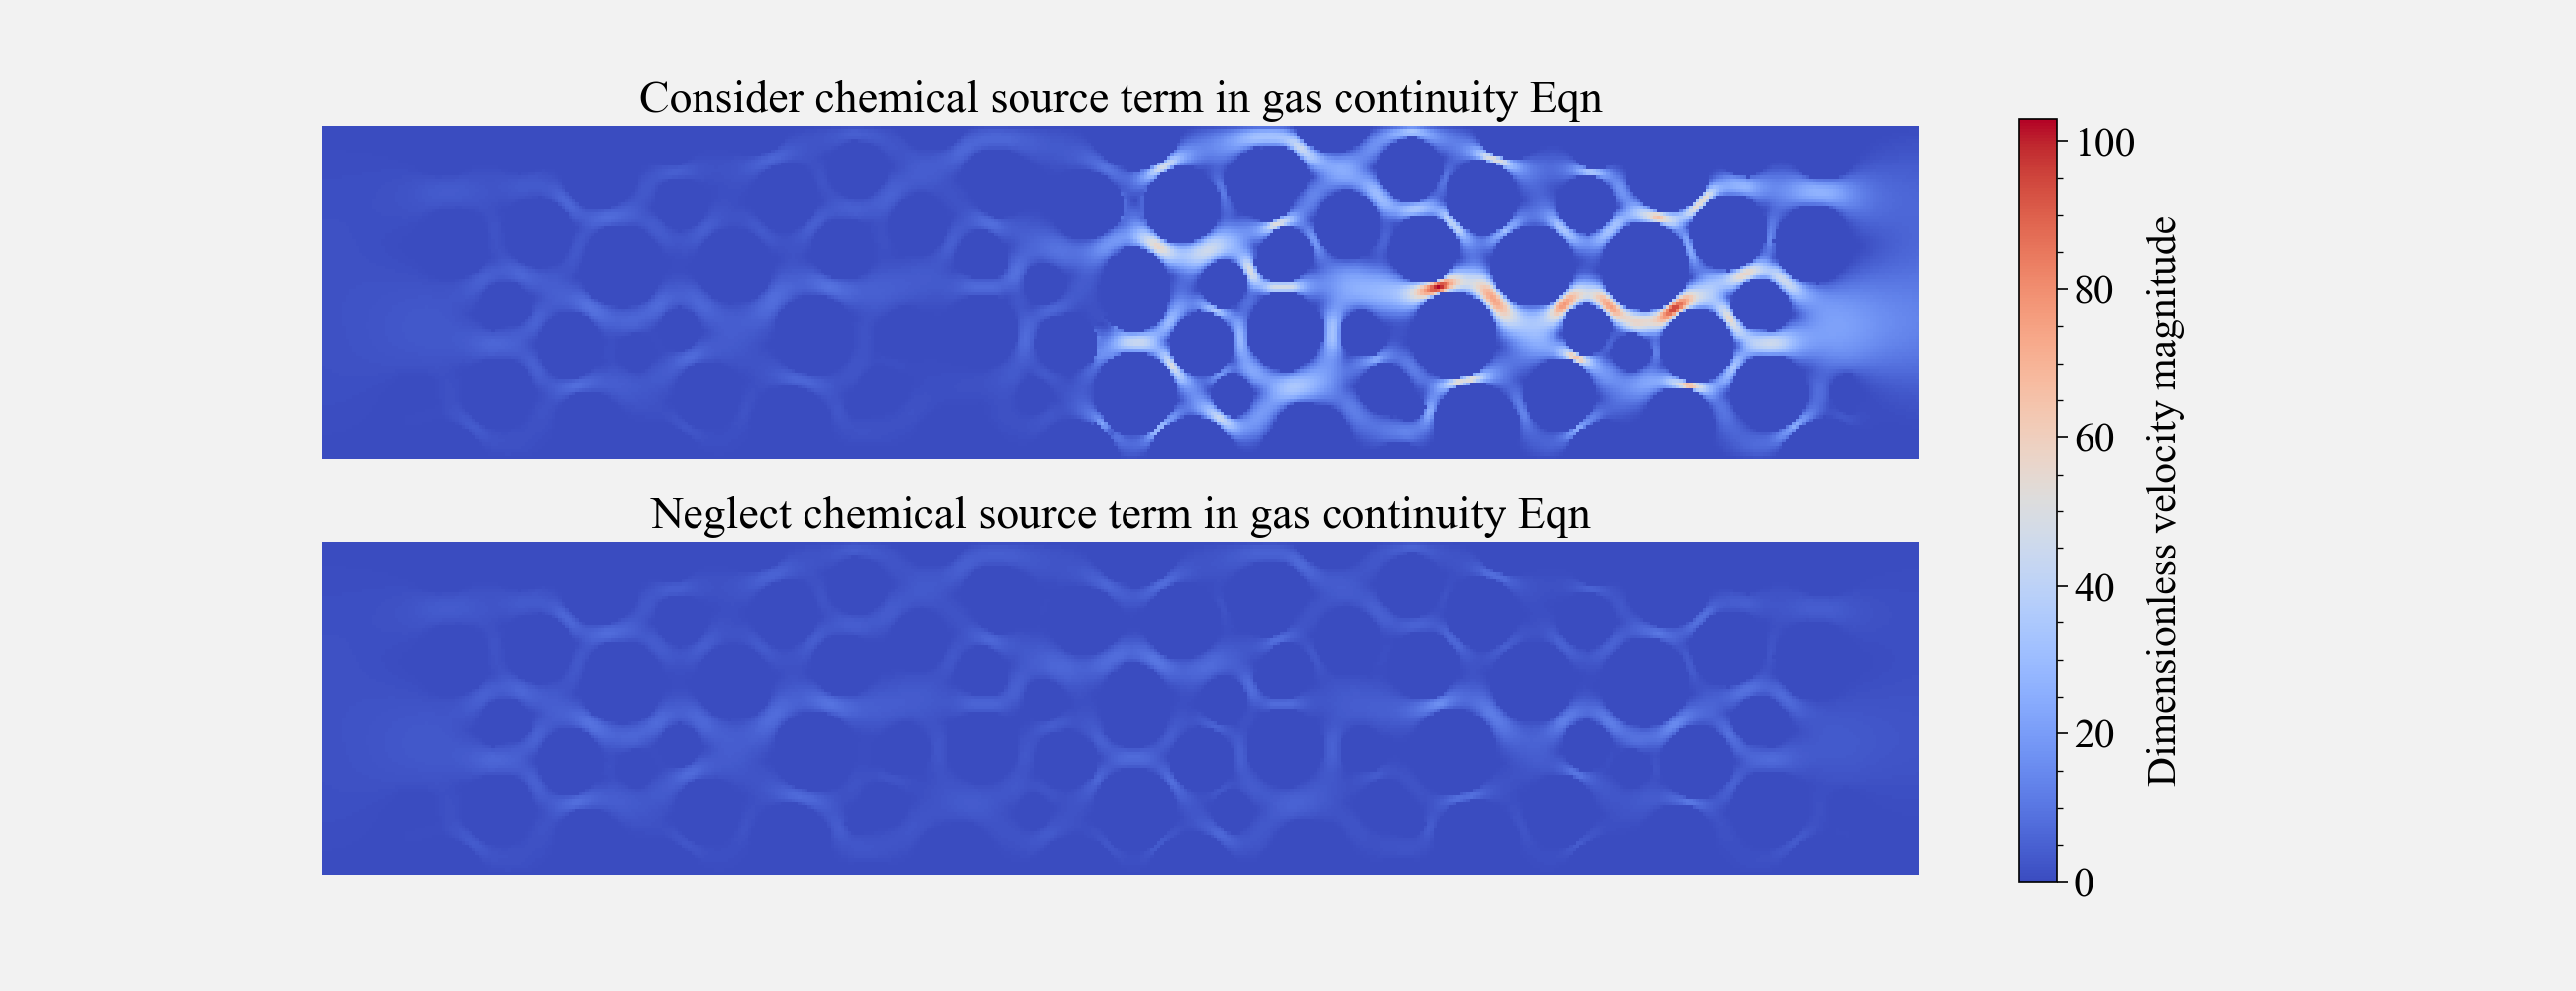

In [12]:
fig, ax=showContour(magU_consider,magU_notConsider,f"Consider chemical source term in gas continuity Eqn",f"Neglect chemical source term in gas continuity Eqn")
fig.savefig("velocityMagnitudeComparison.jpg",bbox_inches='tight',dpi=600)